In [1]:
import torch

In [2]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['image.cmap'] = 'gray'

In [4]:
from torchvision import datasets
from torchvision.transforms import transforms

# Getting the data

In [16]:

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_set = datasets.MNIST('mnist/', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

<img src="mnist.png">

In [6]:
for d in test_loader:
    print(d[0].shape)
    break

torch.Size([64, 1, 28, 28])


# Generator

In [5]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(128, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [23]:
G = generator()

# Discriminator

In [6]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 256), # We flatten the image - 28 x 28 = 784
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [24]:
D = discriminator()

# Hyperparameters

In [25]:
batch_size = 64
epochs = 200
lr = 0.0002
g_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [26]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(1, 128)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0

# Training

In [27]:
# Training Loop
# Code adopted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) same as minimizing BCE
        ###########################
        ## Train with all-real batch
        d_optimizer.zero_grad()
        b_size = data[0].size(0)
        real_data = data[0].squeeze(1).reshape(b_size, -1) # real data
        label = torch.full((b_size,), real_label, dtype=torch.float)
        # Forward pass real batch through D
        output = D(real_data).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 128)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        #print(fake.shape)
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        d_optimizer.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z))) or minimize -log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        # Update G
        g_optimizer.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
    if epoch % 50 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')
        

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Starting Training Loop...


  0%|▍                                                                               | 1/200 [00:45<2:29:56, 45.21s/it]

Model saved.


 26%|████████████████████▏                                                          | 51/200 [38:49<2:03:12, 49.61s/it]

Model saved.


 50%|██████████████████████████████████████▍                                     | 101/200 [1:17:44<1:34:27, 57.25s/it]

Model saved.


 76%|██████████████████████████████████████████████████████████▉                   | 151/200 [1:59:22<40:24, 49.47s/it]

Model saved.


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [2:39:27<00:00, 47.84s/it]


# Generation

In [16]:
G_1 = torch.load('Generator_epoch_150.pth')

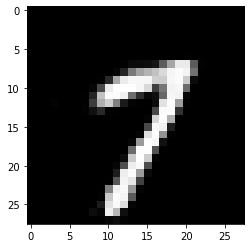

In [18]:
fixed_noise = torch.rand(1, 128)
fake = G_1(fixed_noise).detach()
img = fake.reshape(28, 28)
plt.imshow(img.numpy())